# REACT-Shutter: Analysis in Paper


In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import linregress

In [17]:
plt.rc('font', family='serif')
plt.rcParams["font.family"] ="serif"


## Load and prep data

In [3]:
AU_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r',
           'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r',
           'AU25_r','AU26_r','AU45_r']

of_stats = ['mean','max','25%','50%','75%','std','count']

of_analysis = ['mean','50%','max','std']

stat_names = {'mean':"Mean",'50%':"Median",'max':"Maximum",
              'std':"Std dev"}


In [4]:
info_df = pd.read_csv('../raw_data/react-shutter_summary.csv')
info_df.columns = info_df.columns.str.strip()


In [5]:
photo_order_map = {
    'A' : ['photo_photo0', 'photo_photo1', 'photo_photo2', 'whole_photo0', 'whole_photo1', 'whole_photo2'],
    'B' : ['whole_photo0', 'whole_photo1', 'whole_photo2', 'photo_photo0', 'photo_photo1', 'photo_photo2']
}

In [6]:
summarized_df = pd.read_csv("../processed_data/participant_summaries_facialfeatures.csv")
summarized_df = summarized_df.merge(info_df[['ID','session_order']].drop_duplicates(),how='inner',left_on='id',right_on='ID')


In [7]:
def assign_photo_number(row):
    order_list = photo_order_map[row['session_order']]
    photo_index = order_list.index(row.photo_file)
    return photo_index


summarized_df['photo_num'] = summarized_df.apply(assign_photo_number,axis=1)
summarized_df['file_num'] = summarized_df.apply(lambda row: row['photo_file'] + "_" + str(row['action_num']), axis=1)


In [8]:
def assign_action_num(row):
    action_num = row['action_num']
    if action_num in [1,2,3,4]:
        return row['photo_num']*4+action_num
    else:
        return -1

summarized_df['action_num_1_24'] = summarized_df.apply(assign_action_num,axis=1)

In [9]:
actions_1to24_df = summarized_df[summarized_df['action_num_1_24']!=-1]

## Define functions for plotting and analysis

In [25]:
def plot_actions(df,of_col,of_stat,indep_var):
    if indep_var == "action_num_1_24":
        num_tasks = 6
        s="s"
        plt.figure(figsize=(20,6.5))
        plt.rcParams["font.size"] = 24
        
    elif indep_var == "action_num":
        num_tasks = 1
        s=""
        plt.figure(figsize=(6,4))
        plt.rcParams["font.size"] = 12
        
    
    this_df = df[df['of_col']==of_col]
    
    # add fake data point so plots align
    new_data = pd.DataFrame({indep_var: [0],'of_stat': [0]})
    this_df_bar = pd.concat([new_data, this_df], ignore_index=True)
    
    sns.barplot(data=this_df_bar,x=indep_var,y=of_stat,errorbar="se",color=(148/252, 194/252, 227/252))
    sns.regplot(data=this_df,x=indep_var,y=of_stat,scatter=False,color=(22/252, 60/252, 87/252))
    
    #plt.title(f"Combined AUS and stat: {of_stat}")
    plt.ylabel(f'{stat_names[of_stat]} of AU_sum')
    
    
        
    plt.xlabel(f'Action number over {num_tasks} photography task{s}')
    
    if of_stat == "50%":
        plt.savefig(f'{stat_names[of_stat]}_{of_col}_{indep_var}.pdf')
    
    plt.show()

In [11]:
def lin_regress(df,of_col,of_stat,indep_var):
    this_df = df[df['of_col']==of_col]
    
    lr = linregress(this_df[indep_var],this_df[of_stat],alternative="less")
    if lr.slope > 0:
        lr = linregress(this_df[indep_var],this_df[of_stat],alternative="greater")
    return lr
    

In [12]:
def lin_regress_table(df,of_col,indep_var):
    for of_stat in of_analysis:
        if of_stat == "mean":
            print(f'Statistic & Slope & Intercept & Pearson correlation')
        lr = lin_regress(df,of_col,of_stat,indep_var)
        p_value = lr.pvalue
        sig = ""
        if p_value < .05:
            sig = "*"
        if p_value < .01:
            sig = "**"
        if p_value < .001:
            sig = "***"
        if p_value < .0001:
            sig = "****"
        print(f'{stat_names[of_stat]} & {lr.slope:.3f}{sig} & {lr.intercept:.3f} & {lr.rvalue:.3f} \\\\')

## Analysis considering overall action number

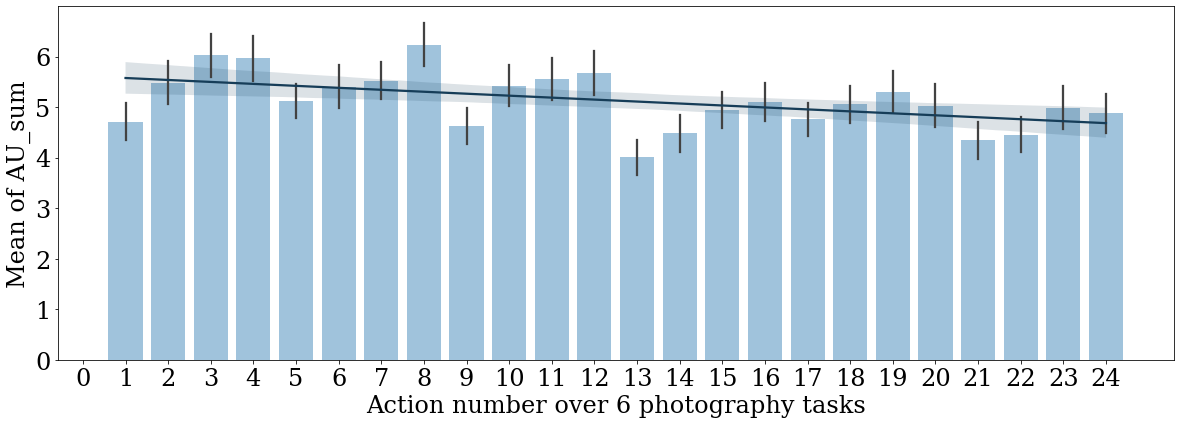

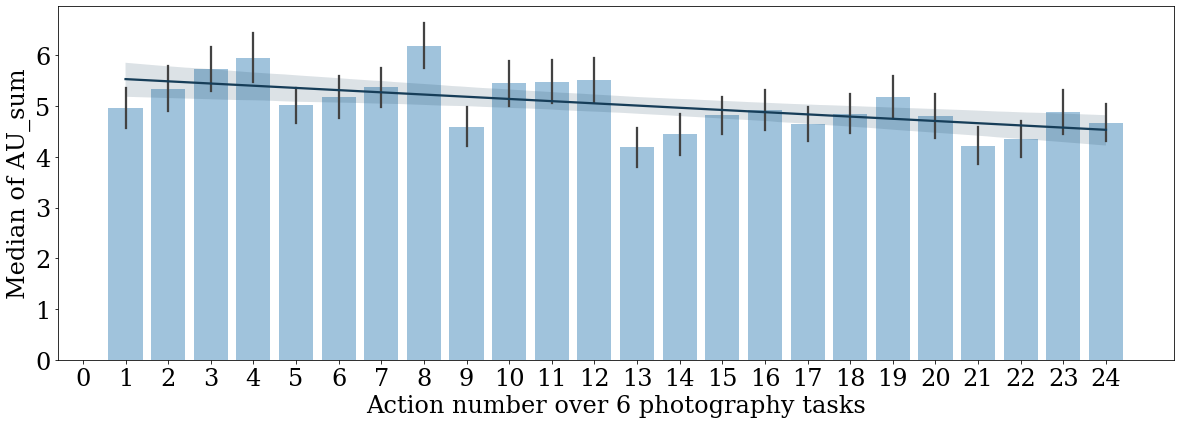

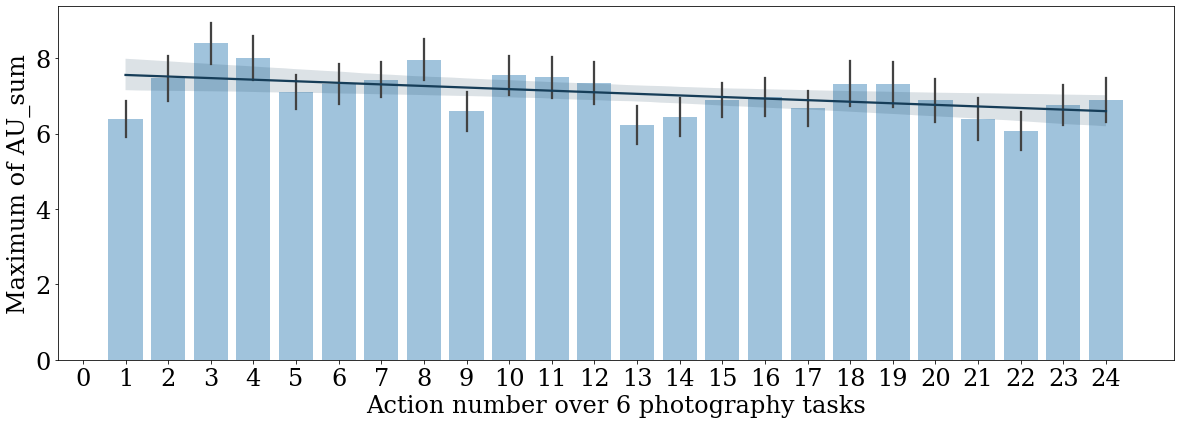

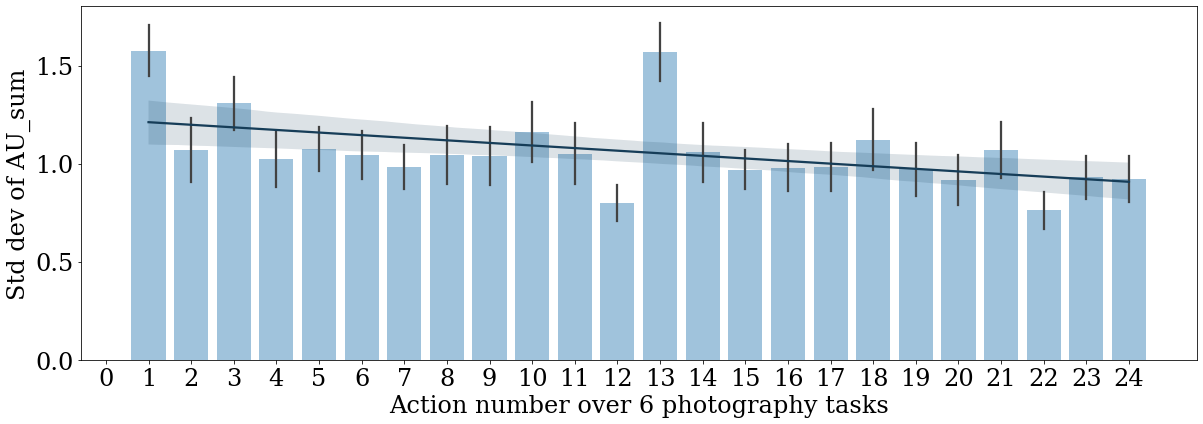

In [26]:
for of_stat in of_analysis:
    plot_actions(actions_1to24_df,"AU_sum",of_stat,'action_num_1_24')
    

In [14]:
lin_regress_table(actions_1to24_df,"AU_sum",'action_num_1_24')

Statistic & Slope & Intercept & Pearson correlation
Mean & -0.039*** & 5.617 & -0.108 \\
Median & -0.043*** & 5.575 & -0.117 \\
Maximum & -0.042** & 7.598 & -0.086 \\
Std dev & -0.013*** & 1.225 & -0.108 \\


## Analysis considering action number for individual photography tasks

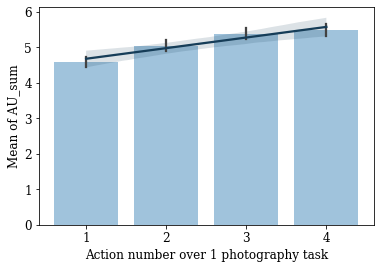

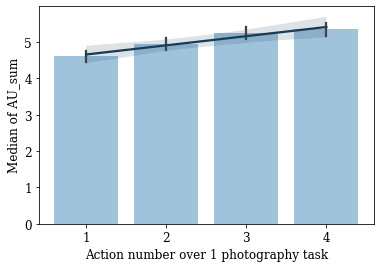

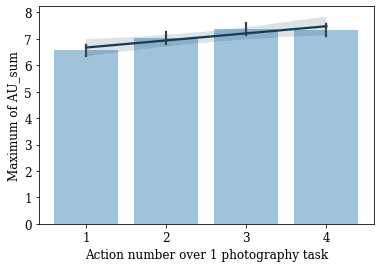

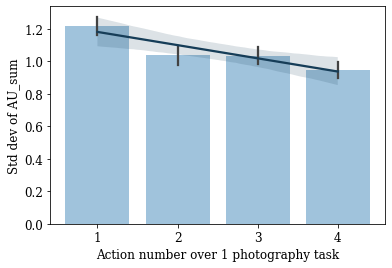

In [22]:
for of_stat in of_analysis:
    plot_actions(actions_1to24_df,"AU_sum",of_stat,'action_num')

In [16]:
lin_regress_table(actions_1to24_df,"AU_sum",'action_num')

Statistic & Slope & Intercept & Pearson correlation
Mean & 0.299**** & 4.383 & 0.134 \\
Median & 0.252*** & 4.402 & 0.110 \\
Maximum & 0.269** & 6.404 & 0.089 \\
Std dev & -0.081*** & 1.263 & -0.107 \\
